In [1]:
#importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from pandas import datetime
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [2]:
#Load the dataset
airlines=pd.read_excel("/content/Airlines+Data.xlsx")
airlines.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [3]:
airlines.shape

(96, 2)

We have the data of sirline passenger of 8 years from 1995 to 2002.

In [ ]:
airlines.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

Creating the 'Month' as Index for data and viewing the dataset.

In [4]:
airlines1=airlines.set_index('Month')

Text(0, 0.5, 'Number of Air Passengers')

<Figure size 1440x720 with 0 Axes>

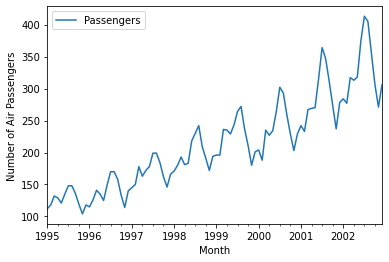

In [5]:
#Visualizing the Time Series plot for the number of Air Passengers
plt.figure(figsize=(20,10))
airlines1.plot()
plt.xlabel("Month")
plt.ylabel("Number of Air Passengers")


We can see alinear trend and multiplicative seasonality in our dataset. Also, our data is not a stationary data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f57f36e7a10>]],
      dtype=object)

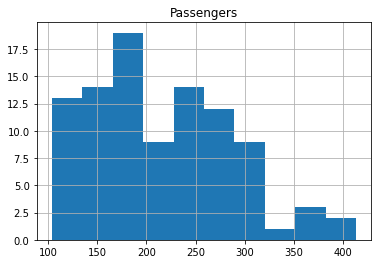

In [6]:
#Histogram
airlines.hist()

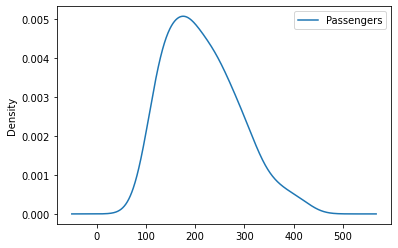

In [7]:
airlines1.plot(kind='kde')

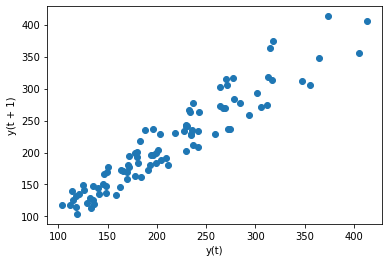

In [8]:
#Lag plot
lag_plot(airlines1)
plt.show()

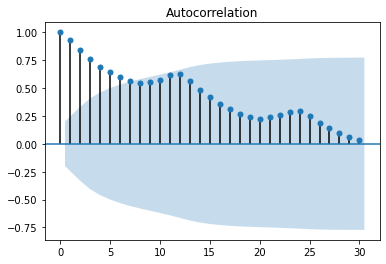

In [9]:
plot_acf(airlines1,lags=30)
plt.show()

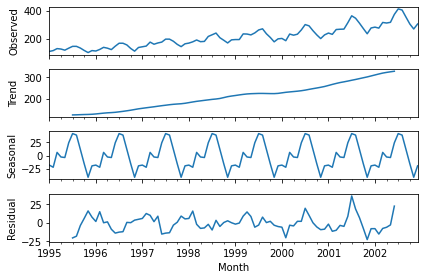

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(airlines1.Passengers)
decompose_ts_add.plot()
plt.show()

The number of passengers increasing with years, hence the data has a strong positive trend. The data also seems to suggest seasonality since there are peaks and dips in the trend.

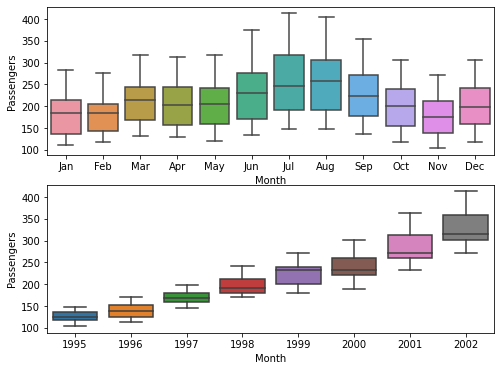

In [11]:
# Boxplot for every month and year
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x=airlines.Month.dt.strftime('%b'),y="Passengers",data=airlines)
plt.subplot(212)
sns.boxplot(x=airlines.Month.dt.strftime('%Y'),y="Passengers",data=airlines)

There are more airline Passengers on average in the month of July and August and June being 3rd, the lowest is seen in November and Feb. The number of passengers also increase every year.

###Test stationarity of the dataset

Rolling mean and standard deviation method

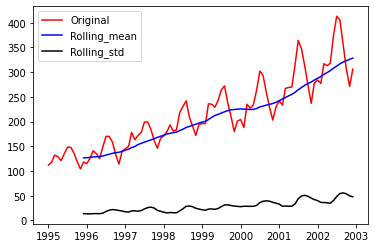

In [12]:
def stationarity(series):
  #Determine rolling statistics
  roll_mean=series.rolling(12).mean()
  roll_std=series.rolling(window=12).std()

  #Plot rolling statistics
  original=plt.plot(series,color="red",label='Original')
  mean=plt.plot(roll_mean,color="blue",label='Rolling_mean')
  std=plt.plot(roll_std,color="black",label='Rolling_std')
  plt.legend(loc='best')
  plt.show(block=False)

stationarity(airlines1)

From the plot, we can say that our data is not stationary as the mean is increasing with time, Both mean and variance are not constant.

Let us do one more test, ADF test.


Augmented Dickey fuller test

Null hupothesis: Series is non stationary     
Alternate: Series is stationary

In [13]:
from statsmodels.tsa.stattools import adfuller
def adf_stationarity(series):
  print("Results of ADF test: ")
  adf_test=adfuller(series,autolag='AIC')
  adf_op=pd.Series(adf_test[0:4],index=['Test Statistic','p-value','Lags used','No of observations'])
  for key,value in adf_test[4].items():
    adf_op['Critical Value (%s)'%key] = value
  print(adf_op)

In [14]:
adf_stationarity(airlines.Passengers)

Results of ADF test: 
Test Statistic           1.340248
p-value                  0.996825
Lags used               12.000000
No of observations      83.000000
Critical Value (1%)     -3.511712
Critical Value (5%)     -2.897048
Critical Value (10%)    -2.585713
dtype: float64


As p-value is greater than 0.05, we fail to reject NUll hypothesis. Also the test statistic is more than the Critical values.Therefore, we can conclude that our data is Non-stationary.

###Transformations to get Stationary series

1. Eliminating the trend 

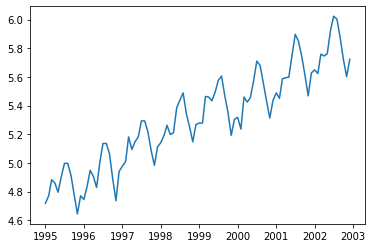

In [32]:
airlines_log=np.log(airlines1)
plt.plot(airlines_log)

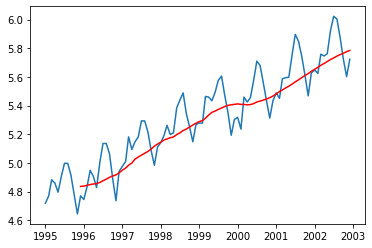

In [33]:
#Moving average method to make the trend constant and to remove the noise(Smoothing technique)
moving_avg = airlines_log.rolling(12).mean()
plt.plot(airlines_log)
plt.plot(moving_avg, color='red')

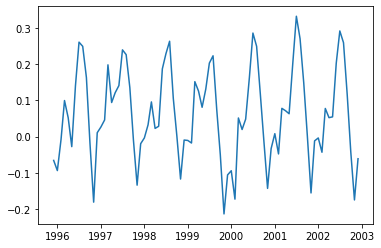

In [34]:
#Subtract the rolling mean from original series to make it stationary
airlines_log_diff=airlines_log-moving_avg
airlines_log_diff.dropna()
plt.plot(airlines_log_diff)

The trend has reduced, we can verify by the following plots.

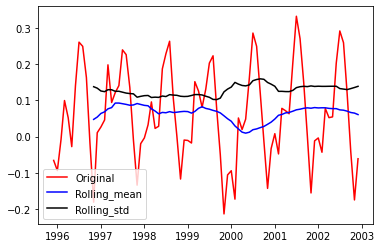

In [35]:
stationarity(airlines_log_diff)

There are little variation in the mean and std. 

In [36]:
adf_stationarity(airlines_log_diff.Passengers.dropna())

Results of ADF test: 
Test Statistic          -1.910930
p-value                  0.326937
Lags used               12.000000
No of observations      72.000000
Critical Value (1%)     -3.524624
Critical Value (5%)     -2.902607
Critical Value (10%)    -2.588679
dtype: float64


The test statistic is smaller than the 10% critical values so we can say with 95% confidence that this is a stationary series. the p-value is greater than 0.05.                               Therefore, we need to look for other approaches.

2. Differencing method

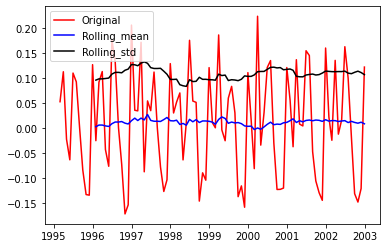

Results of ADF test: 
Test Statistic          -2.670823
p-value                  0.079225
Lags used               12.000000
No of observations      82.000000
Critical Value (1%)     -3.512738
Critical Value (5%)     -2.897490
Critical Value (10%)    -2.585949
dtype: float64


In [65]:
airlines_log_shift1 = airlines_log - airlines_log.shift()
airlines_log_shift1.dropna(inplace=True)
stationarity(airlines_log_shift1)
adf_stationarity(airlines_log_shift1.Passengers)

p-value is still greater than 0.05. We can say that our data is stationary with only 90% confidence. Let us try analysing with 2nd and 3rd differencing.

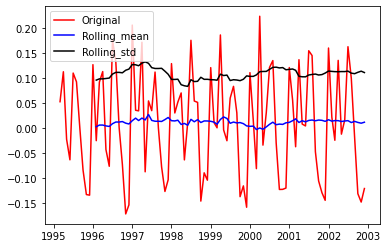

Results of ADF test: 
Test Statistic          -2.668350
p-value                  0.079677
Lags used               12.000000
No of observations      81.000000
Critical Value (1%)     -3.513790
Critical Value (5%)     -2.897943
Critical Value (10%)    -2.586191
dtype: float64


In [38]:
airlines_log_shift2=airlines_log_shift1.shift()
airlines_log_shift2.dropna(inplace=True)
stationarity(airlines_log_shift2)
adf_stationarity(airlines_log_shift2.Passengers)

We can see that our p-value and test statistic is increasing which is not helping our model to become strongly stationary.

3. Decomposing

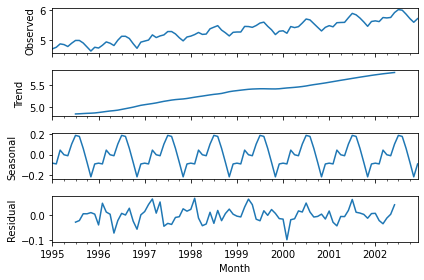

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(airlines_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

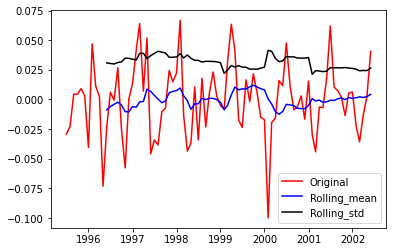

Results of ADF test: 
Test Statistic         -5.907863e+00
p-value                 2.681970e-07
Lags used               3.000000e+00
No of observations      8.000000e+01
Critical Value (1%)    -3.514869e+00
Critical Value (5%)    -2.898409e+00
Critical Value (10%)   -2.586439e+00
dtype: float64


In [40]:
airlines_log_res=residual
airlines_log_res=airlines_log_res.dropna()
stationarity(airlines_log_res)
adf_stationarity(airlines_log_res.Passengers)

ADF test statistic is significantly lower than the 1% critical value and p-value is less than 0.05. So this data series is very close to stationary. Taking decomposed results would not be a great idea as it won't be very intuitive during the forecasting.


Therefore, I consider the first differencing data for further analysis.

###ACF and PACF plots

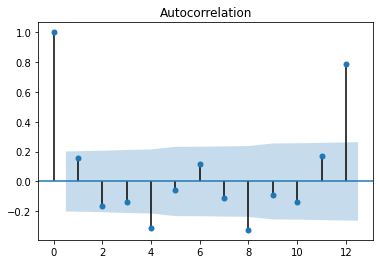

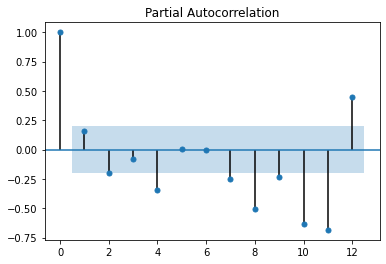

In [24]:
#ACF and PACF plots:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(airlines_log_shift1.Passengers,lags=12)
tsa_plots.plot_pacf(airlines_log_shift1.Passengers,lags=12)
plt.show()  


Now, lets make 3 different ARIMA models considering individual as well as combined effects.

### Moving Average

In [66]:
#airlines_log = airlines_log.resample("M").last()
airlines_log=airlines_log.dropna()

In [67]:
#airlines_log_shift1=airlines_log_shift1.asfreq('M')
airlines_log_shift1=airlines_log_shift1.dropna()

Text(0.5, 1.0, 'RSS: 0.8278')

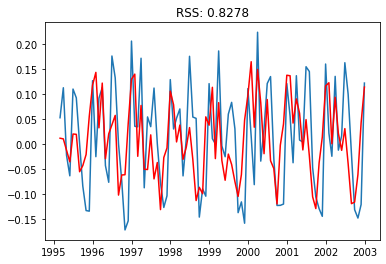

In [68]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(airlines_log, order=(0, 1, 2),freq='M')  #p=0,d=1,q=2
results_MA = model.fit(disp=-1)  
plt.plot(airlines_log_shift1)
plt.plot(results_MA.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-airlines_log_shift1)**2))
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-airlines_log_shift1['Passengers'])**2))

###Auto correlation

Text(0.5, 1.0, 'RSS: 0.9438')

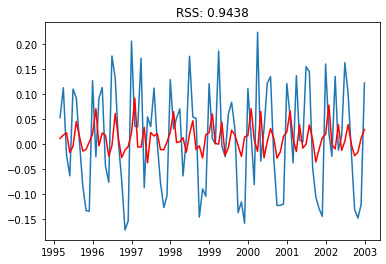

In [69]:
model = ARIMA(airlines_log, order=(3, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(airlines_log_shift1)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-airlines_log_shift1['Passengers'])**2))

###ARiMA

Text(0.5, 1.0, 'RSS: 0.6093')

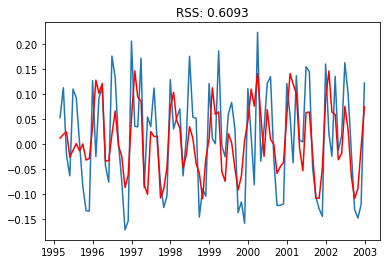

In [70]:
model = ARIMA(airlines_log, order=(2, 1, 4))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(airlines_log_shift1)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-airlines_log_shift1['Passengers'])**2))

We got least RSS in ARIMA model. 

Take the values back to original scale and make predictions

In [58]:
#Fitted values
predictions=pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions.head())

Month
1995-02-28    0.011282
1995-03-31    0.018891
1995-04-30    0.023778
1995-05-31   -0.026702
1995-06-30   -0.012945
Freq: M, dtype: float64


Notice that the values start from second month as we took a lag 1. This can be converted by adding the differences consecutively to the base number and it can be done by cumulative sum.

In [59]:
#Cumulative sum
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Month
1995-02-28    0.011282
1995-03-31    0.030173
1995-04-30    0.053951
1995-05-31    0.027249
1995-06-30    0.014304
Freq: M, dtype: float64


In [60]:
#add cum_sum to base number
predictions_log=pd.Series(airlines_log['Passengers'].iloc[0], index=airlines_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log.head()

Month
1995-01-31    4.718499
1995-02-28    4.729780
1995-03-31    4.748671
1995-04-30    4.772450
1995-05-31    4.745748
Freq: M, dtype: float64

In [61]:
#Take the exponent and compare with the original series
predictions_ARIMA=np.exp(predictions_log)
predictions_ARIMA

Month
1995-01-31    112.000000
1995-02-28    113.270695
1995-03-31    115.430820
1995-04-30    118.208447
1995-05-31    115.093839
                 ...    
2002-08-31    291.564633
2002-09-30    261.346041
2002-10-31    238.914238
2002-11-30    237.212920
2002-12-31    255.444645
Freq: M, Length: 96, dtype: float64

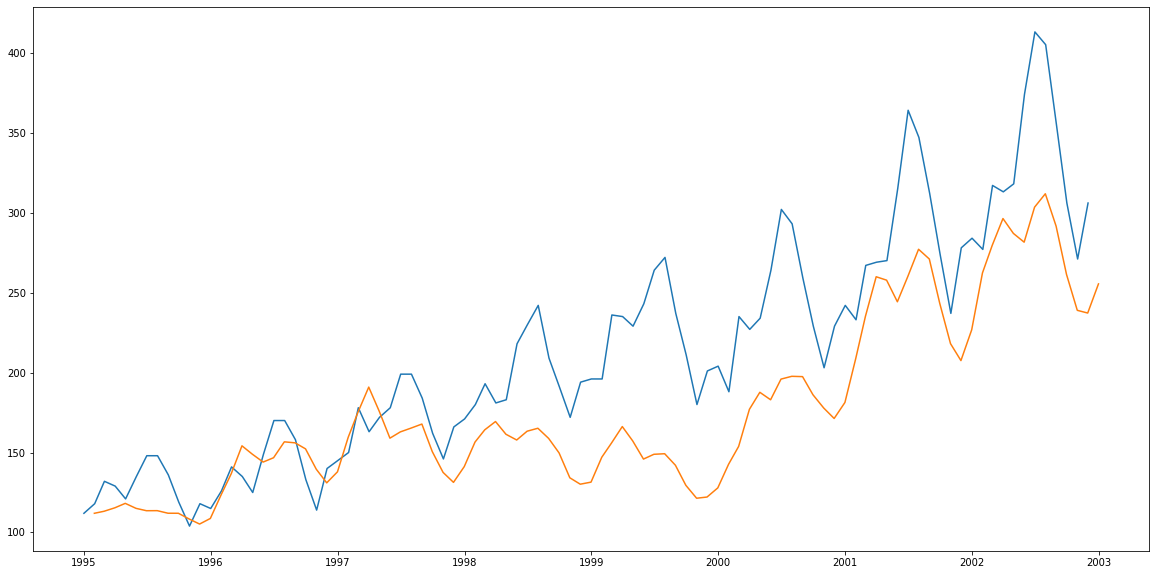

In [62]:
predictions_ARIMA=np.exp(predictions_log)
plt.figure(figsize=(20,10))
plt.plot(airlines1)
plt.plot(predictions_ARIMA)


Next, we shal create an ARIMA model based on the best parameters.

##ARIMA model

In [72]:
# separate out a validation dataset
split_point = len(airlines1) - 12
Dataset, Validation = airlines1[0:split_point], airlines1[split_point:]
print('Dataset %d, Validation %d' % (len(Dataset), len(Validation)))
Dataset.to_csv('Dataset.csv', header=False)
Validation.to_csv('Validation.csv', header=False)

Dataset 84, Validation 12


In [73]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('Dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [ ]:
print(train.reshape(1,len(train)))
print('------------------------------------------------------------------------------')
print(test.reshape(1,len(test)))

[[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
  141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
  172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.]]
------------------------------------------------------------------------------
[[230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
  237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
  203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.]]


In [74]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=218.000, Expected=230.000
>Predicted=230.000, Expected=242.000
>Predicted=242.000, Expected=209.000
>Predicted=209.000, Expected=191.000
>Predicted=191.000, Expected=172.000
>Predicted=172.000, Expected=194.000
>Predicted=194.000, Expected=196.000
>Predicted=196.000, Expected=196.000
>Predicted=196.000, Expected=236.000
>Predicted=236.000, Expected=235.000
>Predicted=235.000, Expected=229.000
>Predicted=229.000, Expected=243.000
>Predicted=243.000, Expected=264.000
>Predicted=264.000, Expected=272.000
>Predicted=272.000, Expected=237.000
>Predicted=237.000, Expected=211.000
>Predicted=211.000, Expected=180.000
>Predicted=180.000, Expected=201.000
>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>

###Arima hyperparameters

In [75]:
# grid search ARIMA parameters for a time series

import warnings
from statsmodels.tsa.arima_model import ARIMA

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [76]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [84]:
# load dataset
train = read_csv('Dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
#evaluate parameters
p_values = range(0, 5)  
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=78.356
ARIMA(0, 0, 1) RMSE=44.790
ARIMA(0, 1, 0) RMSE=26.206
ARIMA(0, 1, 1) RMSE=25.582
ARIMA(0, 1, 2) RMSE=28.099
ARIMA(0, 1, 3) RMSE=23.953
ARIMA(0, 1, 4) RMSE=22.830
ARIMA(0, 2, 0) RMSE=32.545
ARIMA(0, 2, 1) RMSE=26.939
ARIMA(0, 2, 2) RMSE=26.175
ARIMA(1, 0, 0) RMSE=26.445
ARIMA(1, 0, 1) RMSE=25.611
ARIMA(1, 1, 0) RMSE=25.940
ARIMA(1, 2, 0) RMSE=31.784
ARIMA(2, 0, 0) RMSE=25.991
ARIMA(2, 0, 1) RMSE=26.541
ARIMA(2, 1, 0) RMSE=25.659
ARIMA(2, 2, 0) RMSE=30.766
ARIMA(3, 0, 0) RMSE=25.820
ARIMA(3, 0, 1) RMSE=25.376
ARIMA(3, 1, 0) RMSE=25.765
ARIMA(3, 2, 0) RMSE=30.978
ARIMA(4, 0, 0) RMSE=26.056
ARIMA(4, 1, 0) RMSE=25.190
ARIMA(4, 2, 0) RMSE=29.503
ARIMA(4, 2, 1) RMSE=25.848
Best ARIMA(0, 1, 4) RMSE=22.830


###Build Model based on the optimized values

In [85]:
from statsmodels.tsa.arima_model import ARIMA
# prepare data
X = train.values
X = X.astype('float32')

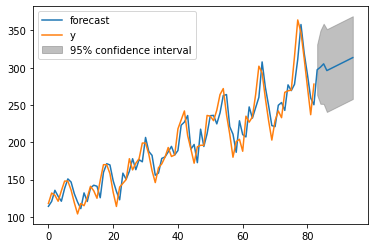

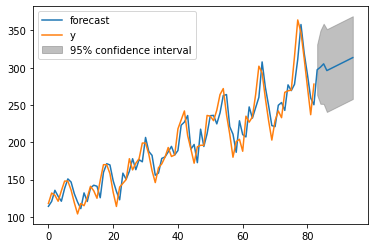

In [86]:
# fit model
model = ARIMA(X, order=(0,1,4))
model_fit = model.fit()
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1, 95)

In [87]:
#Error on the test data
val=pd.read_csv('Validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

52.56525985022698

Combine train and test data and build final model

In [88]:
# fit model
# prepare data
X_data = airlines1.values
X_data = X_data.astype('float32')

In [92]:
full_model = ARIMA(X_data, order=(0,1,4))
model_fit = full_model.fit()

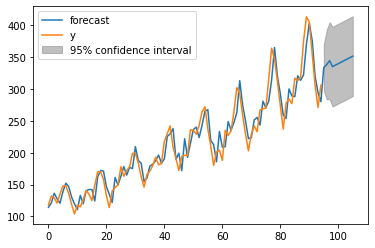

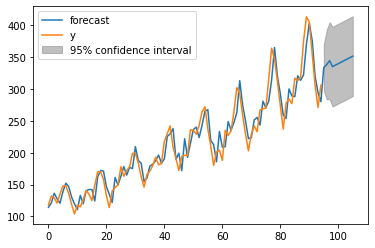

In [102]:
#Forecast the number of passengers for the next one year
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1,106)